In [1]:
import glob
import os
import json
import pickle as pkl
import yaml

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
! ls ../eos/Apr12_presel_2017

DYJetsToLL_M-10to50                     SingleElectron_Run2017E
DYJetsToLL_Pt-100To250                  SingleElectron_Run2017F
DYJetsToLL_Pt-250To400                  SingleMuon_Run2017B
DYJetsToLL_Pt-400To650                  SingleMuon_Run2017C
DYJetsToLL_Pt-50To100                   SingleMuon_Run2017D
DYJetsToLL_Pt-650ToInf                  SingleMuon_Run2017E
GluGluHToTauTau                         SingleMuon_Run2017F
GluGluHToWW_Pt-200ToInf_M-125           TTTo2L2Nu
GluGluZH_HToWW_ZTo2L_M-125              TTToHadronic
HWminusJ_HToWW_M-125                    TTToSemiLeptonic
HWplusJ_HToWW_M-125                     VBFHToWWToLNuQQ_M-125_withDipoleRecoil
HZJ_HToWW_M-125                         WJetsToLNu_HT-100To200
QCD_Pt_1000to1400                       WJetsToLNu_HT-1200To2500
QCD_Pt_1400to1800                       WJetsToLNu_HT-200To400
QCD_Pt_170to300                         WJetsToLNu_HT-2500ToInf
QCD_Pt_1800to2400                       WJetsToLNu_HT-400To600
QCD_Pt_2400to32

# Read cutflows from pkl

In [4]:
def get_sum_sumgenweight(pkl_files, year, sample):
    sum_sumgenweight = 0
    for ifile in pkl_files:
        # load and sum the sumgenweight of each
        with open(ifile, "rb") as f:
            metadata = pkl.load(f)
        sum_sumgenweight = sum_sumgenweight + metadata[sample][year]["sumgenweight"]
    return sum_sumgenweight


def get_xsecweight(pkl_files, year, sample, is_data, luminosity):
    if not is_data:
        # find xsection
        f = open("../fileset/xsec_pfnano.json")
        xsec = json.load(f)
        f.close()
        try:
            xsec = eval(str((xsec[sample])))
        except ValueError:
            print(f"sample {sample} doesn't have xsecs defined in xsec_pfnano.json so will skip it")
            return None

        # get overall weighting of events.. each event has a genweight...
        # sumgenweight sums over events in a chunk... sum_sumgenweight sums over chunks
        xsec_weight = (xsec * luminosity) / get_sum_sumgenweight(pkl_files, year, sample)
    else:
        xsec_weight = 1
    return xsec_weight

def get_cutflow(pkl_files, year, sample, weight, ch):
    """
    Get cutflow from metadata but multiply by xsec-weight
    """
    cuts = {}
    cuts["mu"] = ["trigger", 
            "metfilters", 
            "leptonKin", 
            "fatjetKin", 
            "ht", 
            "oneLepton", 
            "notaus", 
            "leptonInJet", 
            "lep_isolation", 
            "lep_misolation"
           ]
    cuts["ele"] = cuts["mu"][:-1]  # remove lep_misolation
    
    evyield = dict.fromkeys(cuts[ch], 0)
    for ik, pkl_file in enumerate(pkl_files):
        with open(pkl_file, "rb") as f:
            metadata = pkl.load(f)
            if ch == "lep":
                cutflows = metadata[sample][year]["cutflows"]
            else:
                cutflows = metadata[sample][year]["cutflows"][ch]

            for key in evyield.keys():
                evyield[key] += cutflows[key] * weight
    return evyield

In [5]:
channels = ["mu", "ele"]

samples = [
    "HWW", 
    "VH",
    "VBF",
    "ttH",
    "QCD",
    "DYJets",
    "WJetsLNu",
    "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
]

In [6]:
# years = ["2018", "2017", "2016", "2016APV"]
years = ["2017"]

cutflows = {}
for year in years:
    print(f"Processing year {year}")    
    samples_dir = f"../eos/Apr12_presel_{year}"

    cutflows[year] = {}
    
    for ch in channels:
        cutflows[year][ch] = {}

        # get lumi
        with open("../fileset/luminosity.json") as f:
            luminosity = json.load(f)[ch][year]

        condor_dir = os.listdir(samples_dir)

        for sample in condor_dir:

            # get a combined label to combine samples of the same process
            for key in utils.combine_samples:
                if key in sample:
                    sample_to_use = utils.combine_samples[key]
                    break
                else:
                    sample_to_use = sample

            if sample_to_use not in samples:
                continue

            is_data = False
            # if sample_to_use == data_by_ch[ch]:
            if sample_to_use == "Data":
                is_data = True

            print(f"Finding {sample} samples and should combine them under {sample_to_use}")

            out_files = f"{samples_dir}/{sample}/outfiles/"
            pkl_files = glob.glob(f"{out_files}/*.pkl")

            xsec_weight = get_xsecweight(pkl_files, year, sample, is_data, luminosity)
            if sample_to_use not in cutflows[year][ch].keys():
                cutflows[year][ch][sample_to_use] = get_cutflow(pkl_files, year, sample, xsec_weight, ch)
            else:
                temp = get_cutflow(pkl_files, year, sample, xsec_weight, ch)
                for key in cutflows[year][ch][sample_to_use]:
                    cutflows[year][ch][sample_to_use][key] += temp[key]
                    
        print(f"------------------------------------------")                    

Processing year 2017
Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
Finding DYJetsToLL_M-10to50 samples and should combine them under DYJets
Finding DYJetsToLL_Pt-400To650 samples and should combine them under DYJets
Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
Finding HWminusJ_HToWW_M-125 samples and should combine them under VH
Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu
Finding TTToSemiLeptonic samples and should combine them under TTbar
Finding DYJetsToLL_Pt-250To400 samples and should combine them under DYJets
Finding ST_t-channel_top_4f_InclusiveDecays samples and should combine them under SingleTop
Finding ST_s-channel_4f_hadronicDecays samples and should combine them under SingleTop
Finding WJetsToLNu_HT-1200To2500 samples and should combine them under WJetsLNu
Finding WJetsToLNu_HT-200To400 samples and should combine them under WJetsLNu
Finding ST_tW_top_5f_inclusiveDe

In [7]:
cutflows.keys()

dict_keys(['2017'])

In [8]:
cutflows["2017"].keys()

dict_keys(['mu', 'ele'])

In [9]:
cutflows["2017"]["mu"].keys()

dict_keys(['WJetsLNu', 'DYJets', 'VBF', 'VH', 'TTbar', 'SingleTop', 'HWW', 'WZQQ', 'QCD', 'Diboson', 'ttH'])

# Combine different channels

In [10]:
# combine both channels
cutflows_new = {}
for year in years:
    cutflows_new[year] = {}
    for ch in cutflows[year]:
        for sample in cutflows[year][ch]:
            if sample not in cutflows_new[year]:
                cutflows_new[year][sample] = {}

            for cut in cutflows[year][ch][sample]:
                if cut not in cutflows_new[year][sample]:
                    cutflows_new[year][sample][cut] = cutflows[year][ch][sample][cut]
                else:
                    cutflows_new[year][sample][cut] += cutflows[year][ch][sample][cut]
                    
cutflows = cutflows_new

In [11]:
cutflows.keys()

dict_keys(['2017'])

In [12]:
cutflows["2017"].keys()

dict_keys(['WJetsLNu', 'DYJets', 'VBF', 'VH', 'TTbar', 'SingleTop', 'HWW', 'WZQQ', 'QCD', 'Diboson', 'ttH'])

In [55]:
! ls /Users/fmokhtar/Desktop/hww/test/events_dict.pkl

/Users/fmokhtar/Desktop/hww/test/events_dict.pkl


In [56]:
        with open("/Users/fmokhtar/Desktop/hww/test/events_dict.pkl", "rb") as fp:
            events_dict = pkl.load(fp)

In [62]:
events_dict["2017"]["mu"]["QCD"]

,fj_pt,fj_msoftdrop,fj_msoftdrop_nocorr,fj_mass,fj_lsf3,fj_sj1_pt,fj_sj2_pt,fj_tau3,fj_tau2,fj_bjets_ophem,...,fj_ParT_probTopbWqq0c,fj_ParT_probTopbWqq1c,fj_ParT_probTopbWq0c,fj_ParT_probTopbWq1c,fj_ParT_probTopbWev,fj_ParT_probTopbWmv,fj_ParT_probTopbWtauhv,fj_ParT_probTopbWtauev,fj_ParT_probTopbWtaumv,event_weight
2,3660.00,44.269785,53.468750,433.0000,0.086243,1910.00,1065.0000,0.033203,0.051300,0.316650,...,0.001285,0.000828,0.000396,0.000074,0.000371,0.000024,0.000024,3.122436e-06,0.000002,0.000005
3,3212.00,31.955949,37.906250,183.1250,0.113342,1543.00,1476.0000,0.008209,0.016220,0.137817,...,0.000312,0.000485,0.000057,0.000041,0.000027,0.000380,0.000065,6.149695e-06,0.000073,0.000005
4,2684.00,17.345410,19.546875,184.5000,0.812012,1426.00,948.0000,0.011551,0.018127,0.283691,...,0.001460,0.012806,0.002402,0.002789,0.000374,0.587833,0.003342,1.571756e-04,0.062542,0.000005
5,3180.00,33.056370,39.218750,416.5000,0.049255,1856.00,905.0000,0.035919,0.050995,0.443115,...,0.000046,0.000065,0.000010,0.000015,0.000003,0.799718,0.000015,7.424716e-07,0.138304,0.000005
7,3314.00,5.159396,6.011719,526.5000,0.985840,1577.00,1313.0000,0.009689,0.012627,0.218384,...,0.000012,0.000008,0.000060,0.000008,0.000023,0.001514,0.000004,1.294617e-06,0.000020,0.000004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1402,568.00,96.683179,97.812500,99.0625,0.318604,484.75,79.3125,0.029099,0.033661,0.176147,...,0.004152,0.007785,0.050482,0.016556,0.017994,0.027265,0.036183,2.702113e-02,0.020284,0.003119
1403,1196.00,203.271420,204.750000,222.8750,0.552246,934.50,248.1250,0.028229,0.039856,0.180664,...,0.057538,0.021878,0.071155,0.008973,0.031349,0.216699,0.104538,2.419687e-02,0.019863,0.002471
1404,508.25,49.545724,47.281250,76.7500,0.821777,369.75,101.6250,0.029617,0.041321,0.143066,...,0.000131,0.000053,0.000039,0.000008,0.000004,0.023611,0.000187,1.020188e-05,0.109286,0.002306
1409,1516.00,360.394676,373.000000,372.0000,0.950684,1250.00,299.7500,0.008408,0.014038,0.052704,...,0.000138,0.000162,0.000222,0.000516,0.009674,0.783229,0.001788,7.301804e-04,0.192537,0.002660


In [63]:
    with open("/Users/fmokhtar/Desktop/hww/test/make_hists_config.yaml", "r") as stream:
        config = yaml.safe_load(stream)

In [64]:
samples_to_plot = config["samples_to_plot"]
vars_to_plot = config["vars_to_plot"]

In [83]:
for var in vars_to_plot:
    print(var)

fj_minus_lep_m
fj_pt
lep_pt
fj_msoftdrop
fj_bjets_ophem
fj_bjets
lep_fj_dr
lep_met_mt
ht
met_fj_dphi
deta
met
mjj
fj_pt_over_lep_pt
rec_higgs_m
rec_higgs_pt
rec_higgs_pt_over_lep_pt
golden_var
rec_dphi_WW
fj_ParticleNet_mass


In [89]:
    hists = {}
    for var in vars_to_plot:
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            utils.axis_dict[var],
        )

        for sample in samples_to_plot:
            for year in events_dict:
                for ch in events_dict[year]:
                    df = events_dict[year][ch][sample]
                    print(sample)
                    hists[var].fill(samples=sample, var=df[var], weight=df["event_weight"])


HWW
HWW
VH
VH
VBF
VBF
ttH
ttH
QCD
QCD
DYJets
DYJets
WJetsLNu
WJetsLNu
WZQQ
WZQQ
TTbar
TTbar
SingleTop
SingleTop
Diboson
Diboson
Data
Data


In [90]:
hists

{'fj_minus_lep_m': Hist(
   StrCategory([], growth=True, name='samples'),
   Regular(35, 0, 280, name='var', label='Jet - Lepton mass [GeV]'),
   storage=Double()),
 'fj_pt': Hist(
   StrCategory([], growth=True, name='samples'),
   Regular(30, 200, 600, name='var', label='Jet $p_T$ [GeV]'),
   storage=Double()),
 'lep_pt': Hist(
   StrCategory([], growth=True, name='samples'),
   Regular(40, 30, 450, name='var', label='Lepton $p_T$ [GeV]'),
   storage=Double()),
 'fj_msoftdrop': Hist(
   StrCategory([], growth=True, name='samples'),
   Regular(35, 20, 250, name='var', label='Jet $m_{sd}$ [GeV]'),
   storage=Double()),
 'fj_bjets_ophem': Hist(
   StrCategory([], growth=True, name='samples'),
   Regular(35, 0, 1, name='var', label='max btagFlavB (opphem)'),
   storage=Double()),
 'fj_bjets': Hist(
   StrCategory([], growth=True, name='samples'),
   Regular(35, 0, 1, name='var', label='max btagFlavB'),
   storage=Double()),
 'lep_fj_dr': Hist(
   StrCategory([], growth=True, name='sample

In [52]:
import yaml

with open(r'store_file.yaml', 'w') as file:
    documents = yaml.dump(regions_selections, file)

In [51]:
    regions_selections = {
        "cat1_sr": "( (inclusive_score>0.99) & (n_bjets_M < 2) & (lep_fj_dr<0.3) )",
        "wjets_cr": "( (inclusive_score>0.99) & (n_bjets_M < 1) & (lep_fj_dr>0.3) )",
        "tt_cr": "( (inclusive_score<0.90) & (n_bjets_M >=2 ) & (lep_fj_dr>0.3) )",
    }

In [45]:
# Read YAML file
with open("store_file.yaml", 'r') as stream:
    data_loaded = yaml.safe_load(stream)

In [50]:
data_loaded["vars_to_plot"]

['fj_minus_lep_m', 'fj_pt', 'rec_higgs_pt_over_lep_pt']

# Combine different years

In [13]:
# combine all years
cutflows_new = {}
for year in cutflows:
    for sample in cutflows[year]:
        if sample not in cutflows_new:
            cutflows_new[sample] = {}

        for cut in cutflows[year][sample]:
            if cut not in cutflows_new[sample]:
                cutflows_new[sample][cut] = cutflows[year][sample][cut]
            else:
                cutflows_new[sample][cut] += cutflows[year][sample][cut]
                
cutflows = cutflows_new

In [14]:
cutflows.keys()

dict_keys(['WJetsLNu', 'DYJets', 'VBF', 'VH', 'TTbar', 'SingleTop', 'HWW', 'WZQQ', 'QCD', 'Diboson', 'ttH'])

In [15]:
cutflows["TTbar"]

{'trigger': 44406.19581542611,
 'metfilters': 44376.860132490074,
 'leptonKin': 38285.82694127156,
 'fatjetKin': 6758.744550768859,
 'ht': 6747.430856943642,
 'oneLepton': 4637.452848444562,
 'notaus': 3648.295680557382,
 'leptonInJet': 1585.1771898799802,
 'lep_isolation': 1555.6074095649021,
 'lep_misolation': 715.979000547815}

# Plot cutflows

In [16]:
plt.rcParams.update({"font.size": 20})

In [17]:
lumi = 0
for year in years:
    # get lumi
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lumi += json.load(f)[ch][year] 
            
if len(channels)==2:
    lumi /= 2

In [18]:
cut_to_label = {
    "trigger": "Trigger",
    "metfilters": "Metfilters", 
    "leptonKin": "Lepton kinematics", 
    "fatjetKin": "Jet kinematics", 
    "ht": "Hadronic activity", 
    "oneLepton": "One Lepton", 
    "notaus": "No Taus", 
    "leptonInJet": "Lepton inside Jet", 
    "lep_isolation": "Lepton isolation", 
    "lep_misolation": "Lepton mini-isolation" 
}

# plot histograms
color_by_sample = {
    "HWW": "red",
    "VH": "tab:brown",
    "VBF": "tab:gray",
    "ttH": "tab:olive",
    
    "DYJets": "tab:purple",
    "QCD": "tab:orange",
    "TTbar": "tab:blue",
    "WJetsLNu": "tab:green",
    "Others": "tab:grey", 

    "Diboson": "orchid",    
    "WZQQ": "salmon",
    "SingleTop": "tab:cyan",
    
#     "WplusHToTauTau": "tab:cyan",
#     "WminusHToTauTau": "tab:cyan",
#     "ttHToTauTau": "tab:cyan",
#     "GluGluHToTauTau": "tab:cyan",
#     "ZHToTauTau": "tab:cyan",
#     "VBFHToTauTau": "tab:cyan",
}

In [22]:
! ls lol

yes


In [21]:
        if not os.path.exists("lol/yes/"):
            os.makedirs("lol/yes/")

In [19]:
# combine non-dominant backgrounds under others
dominant_bkgs = ["QCD", "WJetsLNu", "TTbar", "DYJets"]
signals = ["HWW", "VH", "VBF", "ttH"]

cutflows["Others"] = dict.fromkeys(cutflows["HWW"], 0)
for sample in cutflows:
    if sample not in signals+dominant_bkgs:
        for cut in cutflows[sample]:
            cutflows["Others"][cut] += cutflows[sample][cut]

In [22]:
# debugging
tot = {}
for sample in cutflows:
    tot[sample] = 0
    for cut in cutflows[sample]:
        tot[sample] += cutflows[sample][cut]
        
tot        

{'WJetsLNu': 107566301.87876146,
 'DYJets': 7060508.036429862,
 'VBF': 2615.503425886187,
 'VH': 18093.054615251993,
 'TTbar': 152717.5704258949,
 'SingleTop': 111916.24204041735,
 'HWW': 13015.544943069468,
 'WZQQ': 1364723.7659528612,
 'QCD': 147936467.2494686,
 'Diboson': 2387893.1303153974,
 'ttH': 26039.98408252367,
 'Others': 7729066.276617352}

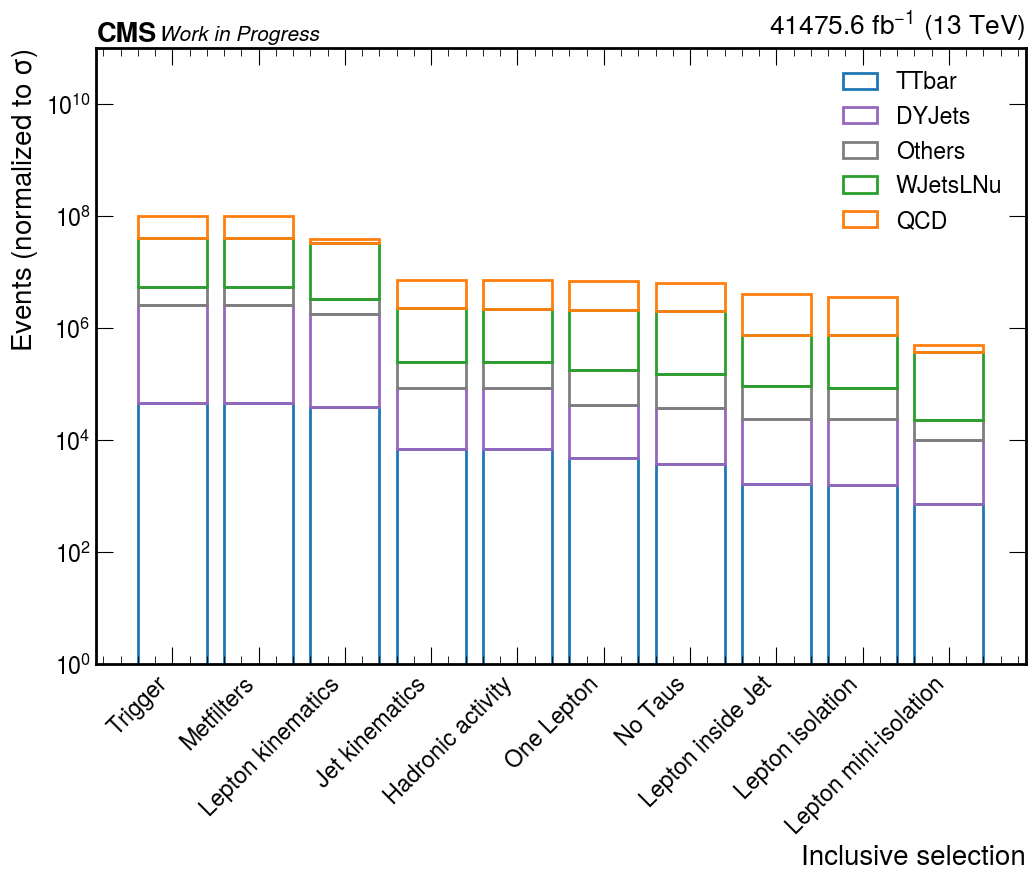

In [23]:
samples = [
#     "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
    "QCD",
    "DYJets",
    "WJetsLNu",
#     "WZQQ",
    "TTbar",
#     "SingleTop",
#     "Diboson",
    "Others"
]

labels = list(cutflows[samples[0]].keys())  
values = [[cutflows[sample][label] for label in labels] for sample in samples]
for i, lab in enumerate(labels):
    labels[i] = cut_to_label[lab]

# Sort the samples by yield
sorted_idx = sorted(range(len(values)), key=lambda i: sum(values[i]), reverse=False)
samples = [samples[i] for i in sorted_idx]
values = [values[i] for i in sorted_idx]

fig, ax = plt.subplots(figsize=(12, 8))
# Plot the cutflows as a stacked bar chart for each sample
bottom = [0] * len(labels)
for i, sample in enumerate(samples):
    if all(v == 0 for v in values[i]):
        print(f"Sample {sample} is empty")
        continue    
    ax.bar(labels, values[i], bottom=bottom, label=sample, edgecolor=color_by_sample[sample], linewidth=2, fill=False)
    bottom = [sum(x) for x in zip(bottom, values[i])]
    
# ax.legend(title="Semi-leptonic channel")
ax.legend()

plt.xticks(rotation=45, ha='right')
ax.set_xlabel('Inclusive selection')
ax.set_ylabel(r'Events (normalized to $\sigma$)')
ax.set_yscale("log")
ax.set_ylim(1,10**11)
 
hep.cms.lumitext(
    "%.1f " % lumi + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15);

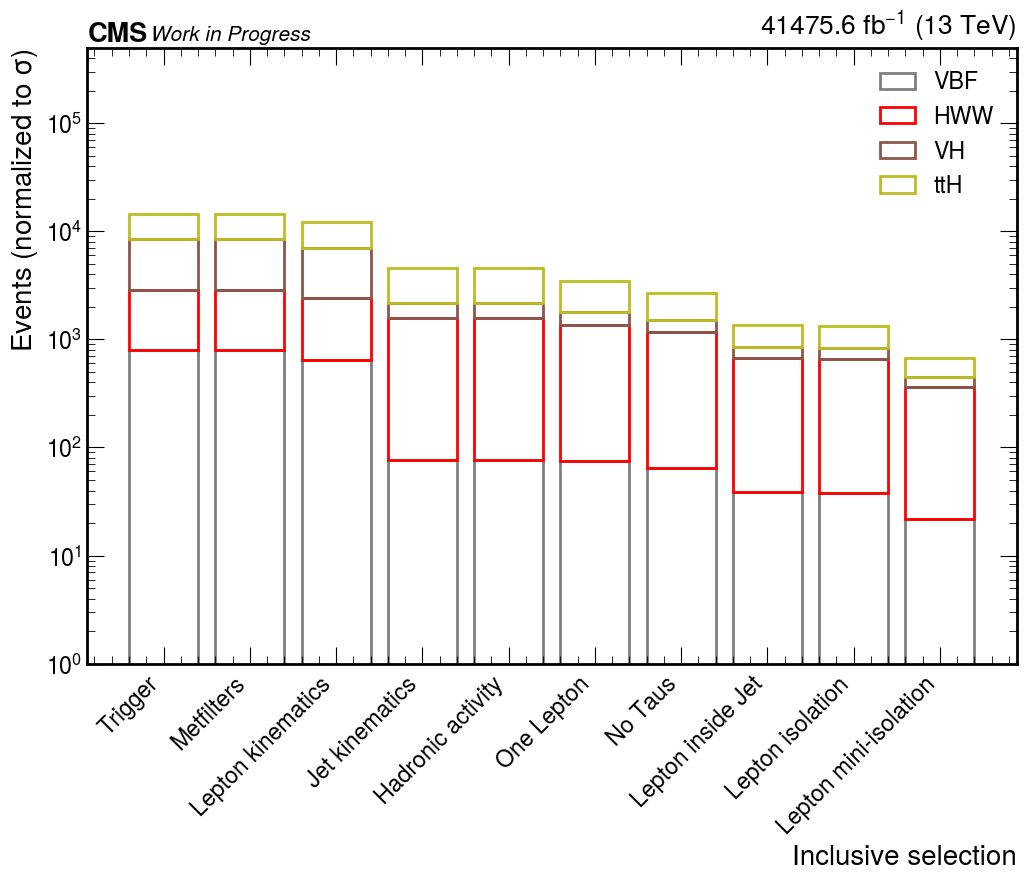

In [24]:
# for signal
samples = [
    "HWW", 
    "VH",
    "VBF",
    "ttH",
#     "QCD",
#     "DYJets",
#     "WJetsLNu",
#     "WZQQ",
#     "TTbar",
#     "SingleTop",
#     "Diboson",
#     "Data"
]

colors = ['blue', 'green', 'red', 'orange']

labels = list(cutflows[samples[0]].keys())
values = [[cutflows[sample][label] for label in labels] for sample in samples]

for i, lab in enumerate(labels):
    labels[i] = cut_to_label[lab]

# Sort the samples by yield
sorted_idx = sorted(range(len(values)), key=lambda i: sum(values[i]), reverse=False)
samples = [samples[i] for i in sorted_idx]
values = [values[i] for i in sorted_idx]

fig, ax = plt.subplots(figsize=(12, 8))
# Plot the cutflows as a stacked bar chart for each sample
bottom = [0] * len(labels)
for i, sample in enumerate(samples):
    if all(v == 0 for v in values[i]):
        print(f"Sample {sample} is empty")
        continue    
    ax.bar(labels, values[i], bottom=bottom, label=sample, edgecolor=color_by_sample[sample], linewidth=2, fill=False)
    bottom = [sum(x) for x in zip(bottom, values[i])]
    
plt.xticks(rotation=45, ha='right')

# ax.legend(title="Semi-leptonic channel")
ax.legend()

plt.xticks(rotation=45, ha='right')
ax.set_xlabel('Inclusive selection')
ax.set_ylabel(r'Events (normalized to $\sigma$)')
ax.set_yscale("log")
ax.set_ylim(1,5*10**5)
 
hep.cms.lumitext(
    "%.1f " % lumi + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15);